In [163]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from multiprocessing import Pool
from bandit import BinaryBandit
from policies import *
from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

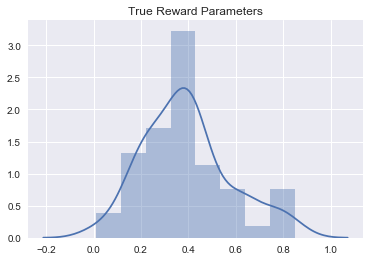

In [200]:
BB = BinaryBandit(K=50, a=2, b=3)
N_PLAYS = 10000
sns.distplot(BB.get_parameters())
plt.title("True Reward Parameters")

First strategy: totally random.

In [201]:
rewards = {}

In [202]:
outcomes, path, rewards["random"] = random_policy(BB, N_PLAYS)

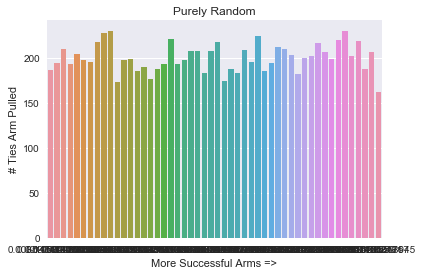

In [203]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Purely Random")

In [204]:
regret(BB.parameters, outcomes)

0.45683565394488124

Somewhat more sophisticated strategy: $\epsilon$-greedy

In [205]:
outcomes, path, rewards["epsilon0.1"] = epsilon_greedy_policy(BB, N_PLAYS, 0.1)

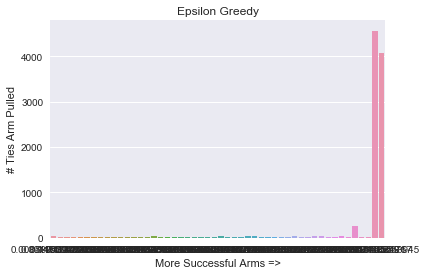

In [206]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Epsilon Greedy")

In [207]:
regret(BB.parameters, outcomes)

0.081635653944881231

Wow! This approach really liked one of the arms. Which one, and how good is it?

In [208]:
BB.parameters[np.argmax(np.apply_along_axis(sum, 1, outcomes))]

0.78974908176743541

In [209]:
max(BB.parameters)

0.85143565394488119

## Boltzmann exploration

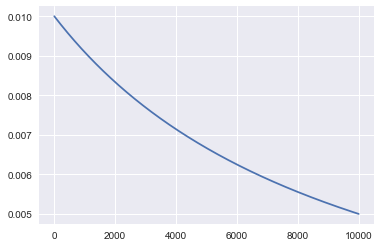

In [210]:
# need to choose a temperature function for Boltzmann exploration
# this one looks good enough
def temp(t):
    return 100 / (N_PLAYS + t)
t = range(N_PLAYS)
T = [temp(s) for s in range(N_PLAYS)]
plt.plot(t, T)

In [211]:
outcomes, path, rewards["boltzmann"] = boltzmann_policy(BB, N_PLAYS, temp)

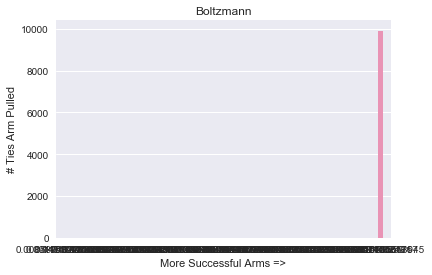

In [212]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Boltzmann")

## UCB1 approach
[source](http://www.yisongyue.com/courses/cs159/lectures/mab.pdf)

In [213]:
outcomes, path, rewards["ucb1"] = ucb1_policy(BB, N_PLAYS)

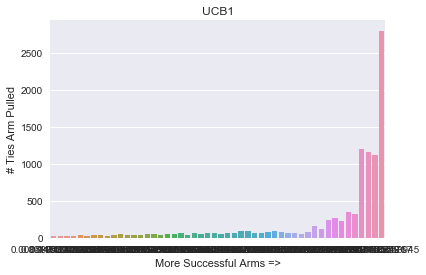

In [214]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("UCB1")

Compared to the $\epsilon$-greedy approach, it looks like we did a lot more exploration

In [215]:
regret(BB.parameters, outcomes)

0.17093565394488122

# Thompson Sampling

In [216]:
outcomes, path, rewards["thompson"]= thompson_policy(BB, N_PLAYS)

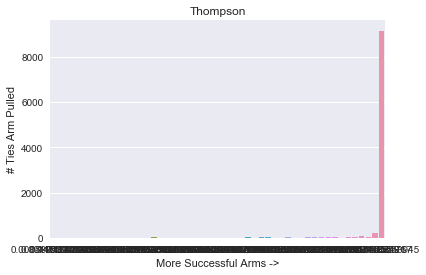

In [217]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms ->")
plt.ylabel("# Ties Arm Pulled")
plt.title("Thompson")

In [218]:
regret(BB.parameters, outcomes)

0.022335653944881233

# Head to head

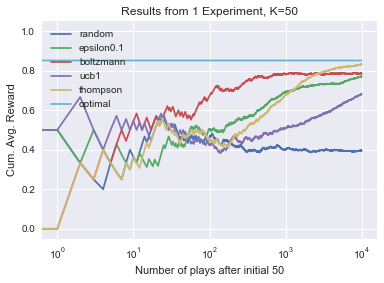

In [219]:
optimal = [max(BB.get_parameters())] * N_PLAYS
for policy in rewards:
    plt.plot(cummean(rewards[policy][BB.get_K():]),
             label=policy)
plt.plot(cummean(optimal[BB.get_K():]),
         label="optimal")
plt.xlabel("Number of plays after initial %d" % BB.get_K())
plt.ylabel("Cum. Avg. Reward")
plt.legend()
plt.title("Results from 1 Experiment, K=%d" % BB.get_K())
plt.xscale("log")

Now that we've illustrated each policy on a single bandit, let's see how they do on average

In [ ]:
def run_experiment(seed):
    np.random.seed(seed)
    BB = BinaryBandit(K=1000)
    n_plays = 10000
    outcomes = [random_policy(BB, n_plays),

               epsilon_greedy_policy(BB, n_plays, 0.1),
               boltzmann_policy(BB, n_plays),
               ucb1_policy(BB, n_plays),
               thompson_policy(BB, n_plays)]
    output = [regret(BB.parameters, r[0], r[1])
                   for r in outcomes]
    return output

In [ ]:
%%time
N_EXPERIMENTS = 100
P = Pool(7)
seeds = np.random.choice(range(1000000), N_EXPERIMENTS, replace=False)
results = P.map(run_experiment, seeds)

In [ ]:
results = \
pd.DataFrame(np.array(results)).\
rename(columns={0: "random",
                1: "epsilon0.05",
                2: "epsilon0.1",
                3: "epsilon0.2",
                4: "ucb1",
                5: "thompson"})

In [ ]:
sns.violinplot(x="variable", y="value",
               data=pd.melt(results))
plt.ylabel("Regret")
plt.xlabel("")

In [ ]:
results.describe()

* At K=1000, 3000 plays: epsilon 10% is the winner